<br><br><br><br><br>

# Coding fast and fast code

<br><br><br><br><br>

<center><img src="img/commute-by-plane.png" width="65%"></center>

_(Stolen from Jake Vanderplas.)_

<br><br><br><br><br>

**Extended analogy:** drive your car to the airport, then take an airplane.

<br><br><br><br><br>

<br><br>

#### Typical analysis workflow

   1. Start with small dataset; plot some things, compute some things, get a sense of the data.
   2. Collect one-liners, notebook cells, scripts into an executable.
   3. Run the executable on ever-larger datasets.
   4. Run it in different ways to quantify systematic errors.
   5. Realize that it wasn't written efficiently enough to finish analysis before deadline.
   6. Rewrite it in a faster language (e.g. Python → C++).
   7. Wonder why the new code doesn't reproduce the old results.

The problem is **step 6**: frameworks should allow you to improve (cleanliness, execution time) in _small steps,_ not _major rewrites._

<br><br>

In [2]:
# Example problem: computing a fractal (calendar/mousepad/T-shirt...).
import time, numpy

def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_python(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

5588.887631893158 ns per pixel


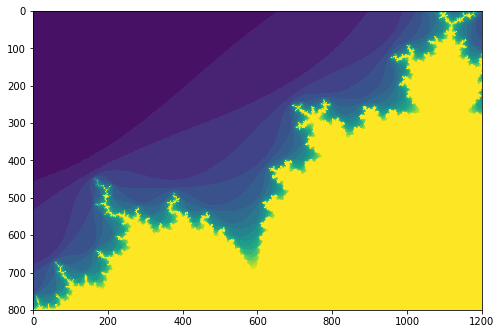

In [3]:
%matplotlib inline
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10, 5.5))
ax.imshow(fractal);

In [5]:
# Numpy operates array-at-a-time, you have to completely rethink the "iterate until converged" part.

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_numpy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

360.25432248910266 ns per pixel


In [11]:
# But once it's in a Numpy-friendly form, it's ready for GPUs.
import cupy

def run_cupy(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]               # <--- changed this line
    c = x + y*1j
    fractal = cupy.full(c.shape, maxiterations, dtype=numpy.int32)   # <--- changed this line
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_cupy(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

73.40045024951299 ns per pixel


In [15]:
# Dask can keep all of your processors busy, but it might be making a more complex graph than you want.
import dask.array

def run_dask(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = chunked(x + y*1j)
    fractal = chunked(numpy.full(c.shape, maxiterations, dtype=numpy.int32))
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_dask(1600, 2400).compute()
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

217.86360690991083 ns per pixel


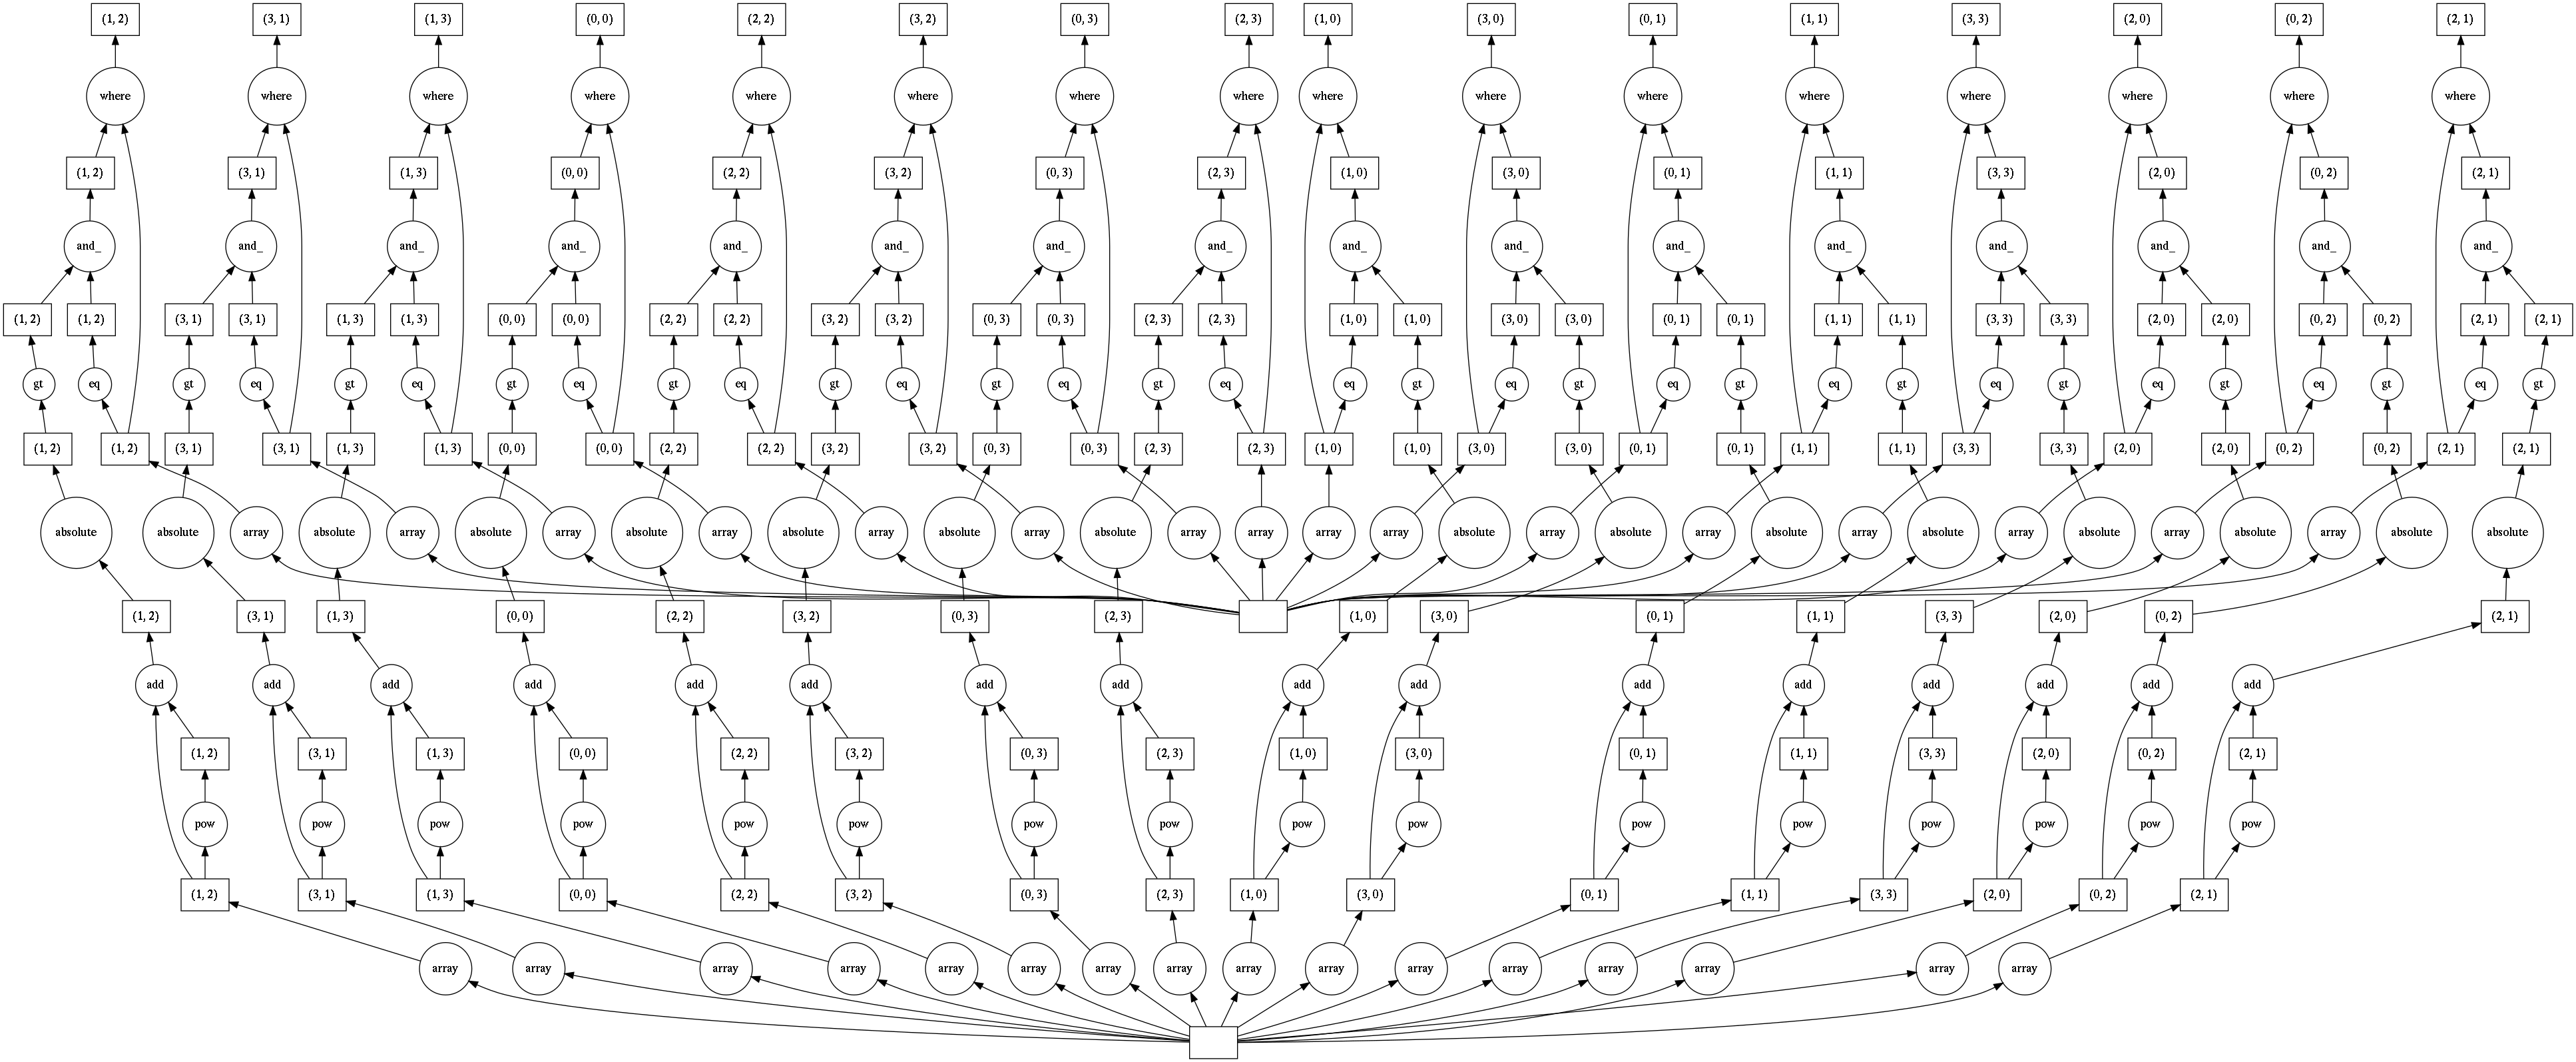

In [16]:
run_dask(1600, 2400, maxiterations=1, hchunks=3, vchunks=4).visualize()

In [26]:
# Numba, on the other hand, lets you run the original Python code, but faster.
import numba

@numba.jit
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

112.56280122324824 ns per pixel


In [47]:
# Numba also has an OpenMP-like, "parallel for" (prange) to parallelize without complex dependencies.
import numba

@numba.jit(parallel=True)
def run_numba_parallel(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in numba.prange(height):
        for w in numba.prange(width):           # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba_parallel(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

34.844980109483004 ns per pixel


In [49]:
# Numba can compile to GPUs, too, but you have to identify the kernel and set block sizes.
import numba.cuda, math
def run_numba_cuda(height, width, maxiterations=20):
    fractal = numpy.empty((height, width), dtype=numpy.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    inner_loop_cuda[griddim, blockdim](height, width, maxiterations, fractal)
    return fractal
@numba.cuda.jit
def inner_loop_cuda(height, width, maxiterations, fractal):
    x, y = numba.cuda.grid(2)                   # 2-dimensional CUDA grid
    z = c = -1.5 + y*1.0/(height + 1) + -1j + x*1j*1.5/(width + 1)
    fractal[x, y] = maxiterations
    for i in range(maxiterations):      # iterate at most 20 times
        z = z**2 + c                    # applying z → z² + c
        if abs(z) > 2:                  # if it diverges (|z| > 2)
            fractal[x, y] = i           # color the plane with the iteration number
            break                       # we're done, no need to keep iterating
starttime = time.time()
fractal = run_numba_cuda(12800, 19200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (12800 * 19200)))

7.030631725986798 ns per pixel


In [50]:
%load_ext Cython

# Cython is a language that mixes C++ and Python. Can it help?

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [51]:
%%cython --cplus
import cython, numpy       # load Python interface to Numpy
cimport numpy              # load C++ interface to Numpy (types end in _t)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    cdef numpy.ndarray[numpy.complex128_t, ndim=2, mode="c"] c_array = c
    cdef numpy.ndarray[numpy.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef numpy.complex128_t z
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(maxiterations):
                z = z**2 + c_array[h, w]
                if abs(z) > 2:
                    fractal_array[h, w] = i
                    break
    return fractal

In [53]:
# Even with all the work we had to do, Cython's performance is underwhelming.

starttime = time.time()
fractal = run_cython(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

1493.2806293169658 ns per pixel
